# Lab 4

In this lab, you will implement functions to train neural networks to predict the specie of a raising. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Functions

###----- activation functions and it's derivative -----###
def sigmoid(x):
    """
    compute sigmoid activation
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """
    compute derivative of sigmoid activation
    """
    return sigmoid(x) * (1 - sigmoid(x))

def identity(x):
    """
    identity function
    """
    return x

def identity_deriv(x):
    """
    derivative of identity function
    """
    return 1

###----- loss functions and it's derivative -----###
def mse(y_true, y_pred):
    """
    compute mean squared error (MSE)
    """
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    """
    compute derivative of MSE
    """
    return (y_pred - y_true)/y_true.size # can be used to mini-batch

def cross_entropy(y_true, y_pred):
    """
    compute cross entropy loss
    """
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12) # clips y_pred to avoid numerical instability

    entropy = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    mean_entropy = np.mean(entropy) #use mean, not sum

    return mean_entropy

def cross_entropy_prime(y_true, y_pred):
    """
    compute derivative of cross entropy loss
    """
    return (y_pred - y_true)/y_true.size # can be used to mini-batch

#Classes
class MyStandardScaler:
    """
    custom implementation of standard scaler for feature scaling.
    """
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

###----- layer -----###
class Layer():
    """
    layer for neural networks. it was coded to be the layer between the hiddens (the lines in the draw)
    """
    def __init__(self, input_size, output_size, activation, activation_prime):
        """
        initialize the layer
        """
        self.input = None
        self.output = None
        self.output_without_activation = None
        self.weights = np.random.rand(input_size, output_size) * 0.1
        self.bias = np.random.rand(1, output_size) * 0.1
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        """
        perform forward propagation through the layer, including activation.
        """
        self.input = input_data.reshape(1, -1)
        self.output_without_activation = np.dot(self.input, self.weights) + self.bias
        self.output = self.activation(self.output_without_activation)
        return self.output

    def backward_propagation(self, delta_k, learning_rate, alpha):
        """
        perform backpropagation through the layer. Use weight decay regularization.

        Args:
            delta_k: delta for each neuron from subsequent layer (was executed previously)
            learning_rate: learning rate for updating parameters.
            alpha: regularization parameter.

        Returns:
            delta_j: delta for each neuron in this layer
        """
        delta_k_activated = self.activation_prime(self.output_without_activation) * delta_k
        delta_j = np.dot(delta_k_activated, self.weights.T)
        gradiente = np.dot(self.input.T, delta_k_activated)

        # regularization term
        self.weight_decay_term = alpha * self.weights

        # update parameters
        self.weights -= learning_rate * gradiente
        self.bias -= learning_rate * delta_k_activated # 1 * delta_k_activated, because input is 1 for bias
        return delta_j

###----- neural network -----###
class Network:
    """
    neural network model for training and prediction. put all the layers together
    """
    def __init__(self):
        """
        initialize the neural network model.
        """
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.alpha = None
        self.y_val = None
        self.x_val = None
        self.errors_during_train = []
        self.errors_during_train_val = []

    def add(self, layer):
        """
        add a layer to the network.
        """
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime, x_val, y_val, alpha = 0.1,):
        """
        set usefull parameters for the network, as loss function.
        """
        self.loss = loss
        self.loss_prime = loss_prime
        self.alpha = alpha
        self.y_val = y_val
        self.x_val = x_val

    def plot_errors(self, separate = False, val_or_test = "val"):
        """
        plot the training and validation errors.

        Args:
            separate: can be used to plot train and validation in different graphs
            val_or_test: used to adapt the plot to use test dataset
        """
        if separate:
            #if you want to plot val and train in different graphs
            _, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

            axes[0].plot(self.errors_during_train, label='train')
            axes[1].plot(self.errors_during_train_val, label=val_or_test, color='orange')

            for axie in axes:
                axie.set_ylabel('Error')
                axie.legend()

            axes[1].set_xlabel('Epoch')

            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"

            axes[0].text(0, -0.15, string_min_error, fontstyle='italic', fontsize=9, transform=axes[0].transAxes)
            axes[1].text(0, -0.15, string_min_error_val, fontstyle='italic', fontsize=9, transform=axes[1].transAxes)

            plt.tight_layout()
            plt.show()
        else:
            #default plot, train and val together
            plt.figure(figsize=(10, 4))
            plt.plot(self.errors_during_train, label='train')
            plt.plot(self.errors_during_train_val, label=val_or_test)

            string_min_error = f"minimum error (train): {min(self.errors_during_train):.5f}"
            string_min_error_val = f"minimum error ({val_or_test}): {min(self.errors_during_train_val):.5f}"

            plt.xlabel('epoch')
            plt.ylabel('error')
            plt.title('Error during training')

            plt.legend()

            plt.text(0, -0.15, string_min_error, fontstyle='italic', fontsize = 9, transform=plt.gca().transAxes)
            plt.text(1, -0.15, string_min_error_val, fontstyle='italic', fontsize = 9 , ha='right', transform=plt.gca().transAxes)

            plt.show()

    def predict(self, input_data):
        """
        predict output for given input data.
        """
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return np.array(result)

    def fit(self, x_train, y_train, epochs, learning_rate, print_erro = False):
        """
        use backpropagation learn the weights.

        Args:
            print_erro : whether to print error during training.
        """

        samples = len(x_train)

        # training loop
        for i in range(epochs):
            loss_train = 0

            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss
                loss_train += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate, self.alpha)

            # calculate average error on all samples
            loss_train /= samples
            self.errors_during_train.append(loss_train)

            # calculate the loss in the validation set
            y_pred_val = self.predict(self.x_val)
            loss_val = np.mean(self.loss(self.y_val, y_pred_val))
            self.errors_during_train_val.append(loss_val)

            if print_erro: print('epoch %d/%d   error_train=%f; error_val=%f' % (i+1, epochs, loss_train, loss_val))


In [3]:
#your code goes here
train_data = pd.read_csv('Raisin_train.csv')
test_data = pd.read_csv('Raisin_test.csv')

X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

def manual_label_encoder(y_train, y_test):
        """
        Implementação manual do label encoder usando numpy e pandas
        """
        # Encontrar classes únicas nos dados de treino
        unique_classes = np.unique(y_train)
        print(f"Classes únicas encontradas: {unique_classes}")

        # Criar mapeamento de classe para número
        class_to_num = {cls: i for i, cls in enumerate(unique_classes)}
        num_to_class = {i: cls for i, cls in enumerate(unique_classes)}

        print(f"Mapeamento classe -> número: {class_to_num}")

        # Aplicar transformação
        y_train_encoded = np.array([class_to_num[cls] for cls in y_train])
        y_test_encoded = np.array([class_to_num[cls] for cls in y_test])

        return y_train_encoded, y_test_encoded, unique_classes, class_to_num, num_to_class


y_train, y_test, unique_classes, class_to_num, num_to_class = manual_label_encoder(y_train, y_test)

# Normalizing the data using pandas and numpy
X_train_scaled = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test_scaled = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

Classes únicas encontradas: ['Besni' 'Kecimen']
Mapeamento classe -> número: {'Besni': 0, 'Kecimen': 1}


Use part of the training set as validation set

In [4]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

Built a function that trains a neural network using the training set and that stop at a predefined number of epochs.

In [5]:
#your code goes here
def train_neural_network(X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01,
                        hidden_size=10, alpha=0.01):
    """
    Treina uma rede neural com os dados fornecidos

    Args:
        X_train: dados de treino
        y_train: labels de treino
        X_val: dados de validação
        y_val: labels de validação
        epochs: número de épocas
        learning_rate: taxa de aprendizado
        hidden_size: tamanho da camada oculta
        alpha: parâmetro de regularização

    Returns:
        network: rede neural treinada
    """
    # Criar a rede neural
    network = Network()

    # Adicionar camadas
    network.add(Layer(X_train.shape[1], hidden_size, sigmoid, sigmoid_deriv))
    network.add(Layer(hidden_size, hidden_size, sigmoid, sigmoid_deriv))
    network.add(Layer(hidden_size, 1, sigmoid, sigmoid_deriv))

    # Configurar função de perda
    network.use(cross_entropy, cross_entropy_prime, X_val, y_val, alpha)

    # Treinar a rede
    network.fit(X_train, y_train, epochs, learning_rate)

    return network

Built a function that predicts using the trained neural network.

In [6]:
#your code goes here
def predict_neural_network(network, X):
    """
    Faz predições usando a rede neural treinada

    Args:
        network: rede neural treinada
        X: dados para predição

    Returns:
        predictions: predições da rede
    """
    predictions = network.predict(X)
    return predictions.flatten()

Build a function that outputs the points you need to plot the ROC curve given a set of true labels and the correspondant predictions.

In [18]:
#your code goes here
def calculate_roc_points(y_true, y_scores):
    """
    Calcula os pontos necessários para plotar a curva ROC

    Args:
        y_true: labels verdadeiros (0 ou 1)
        y_scores: scores/probabilidades preditas

    Returns:
        fpr: taxa de falsos positivos
        tpr: taxa de verdadeiros positivos
        thresholds: limiares utilizados
    """
    # Ordenar por score decrescente
    desc_score_indices = np.argsort(y_scores, kind="mergesort")[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # Criar thresholds únicos
    distinct_value_indices = np.where(np.diff(y_scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    thresholds = y_scores[threshold_idxs]

    # Calcular TPR e FPR
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps

    # Adicionar ponto inicial (0,0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    thresholds = np.r_[thresholds[0] + 1, thresholds]

    # Calcular taxas
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]

    return fpr, tpr, thresholds

Built a function that compute the area under the ROC curve using the points your last function outputs.

In [8]:
def calculate_auc(fpr, tpr):
    """
    Compute the Area Under the ROC Curve (AUROC) using the trapezoidal rule.

    Args:
        fpr: List of false positive rates.
        tpr: List of true positive rates.

    Returns:
        auc: Computed area under the ROC curve.
    """
    auc = 0.0
    for i in range(1, len(fpr)):
        # Calculate the width and height of the trapezoid
        width = fpr[i] - fpr[i - 1]
        height = (tpr[i] + tpr[i - 1]) / 2
        # Add the area of the trapezoid to the total AUC
        auc += width * height
    return auc

Select your hyperparameters by evaluating a number of models in the validation set

In [9]:
#your code here
best_auc = 0
best_params = {}
results = []

# Grid de hiperparâmetros para testar
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [15, 20, 30]
alphas = [0.01, 0.1, 0.5]
epochs = 100

for lr in learning_rates:
    for hs in hidden_sizes:
        for alpha in alphas:
            # Treinar rede
            network = train_neural_network(X_train_final, y_train_final, X_val, y_val,
                                         epochs=epochs, learning_rate=lr,
                                         hidden_size=hs, alpha=alpha)

            # Fazer predições no conjunto de validação
            val_predictions = predict_neural_network(network, X_val)

            # Calcular ROC e AUC
            fpr, tpr, _ = calculate_roc_points(y_val, val_predictions)
            auc = calculate_auc(fpr, tpr)

            results.append({
                'lr': lr, 'hidden_size': hs, 'alpha': alpha, 'auc': auc
            })

            # Atualizar melhores parâmetros
            if auc > best_auc:
                best_auc = auc
                best_params = {'lr': lr, 'hidden_size': hs, 'alpha': alpha}

print(f"\nMelhores parâmetros: {best_params}")
print(f"Melhor AUC na validação: {best_auc:.4f}")


Melhores parâmetros: {'lr': 0.1, 'hidden_size': 20, 'alpha': 0.01}
Melhor AUC na validação: 0.9554


Add your validation set to the training set, train your final neural network model. Assess you final model using the test set. Plot the ROC curve and include the auroc.

In [10]:
#your code goes here
X_train_combined = np.vstack([X_train_final, X_val])
y_train_combined = np.hstack([y_train_final, y_val])

# Treinar modelo final com melhores hiperparâmetros
final_network = train_neural_network(X_train_combined, y_train_combined,
                                   X_test_scaled, y_test,
                                   epochs=150,
                                   learning_rate=best_params['lr'],
                                   hidden_size=best_params['hidden_size'],
                                   alpha=best_params['alpha'])

In [21]:
# Avaliação no conjunto de teste
test_predictions = predict_neural_network(final_network, X_test_scaled)

# Calcular ROC e AUC para o teste
fpr_test, tpr_test, _ = calculate_roc_points(y_test, test_predictions)
auc_test = calculate_auc(fpr_test, tpr_test)

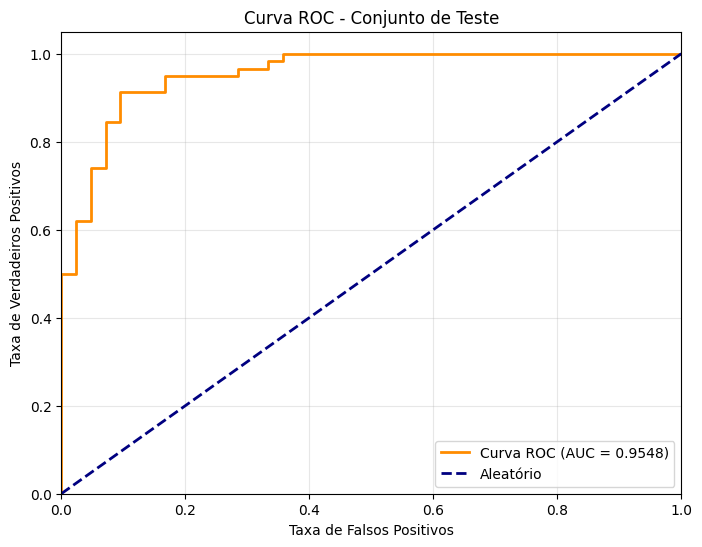


Resultados finais no conjunto de teste:
AUC: 0.9548
Classes: ['Besni' 'Kecimen']


In [26]:
# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f'Curva ROC (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Conjunto de Teste')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nResultados finais no conjunto de teste:")
print(f"AUC: {auc_test:.4f}")
print(f"Classes: {unique_classes}")
